In [1]:
from flask import Flask, request, Blueprint,jsonify,current_app
from app.lib.Base64Converter import url_to_img,path_to_base64
from app.lib.Polygon import PolygonSet,Polygon

#from lib.SMILE import SMILE
import uuid
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os

#from flask_mail import Mail, Message



class SMILE:
    def __init__(self,input_path):
        #####Input/output#####
        self.input_path=input_path 

        self.output_path=f"output.{input_path.split('.')[-1]}" #圖片輸出路徑



        #####Image normalize#####
        self.img=cv2.imread(input_path)
        h, w ,d= self.img.shape
        #self.img=cv2.resize(img, (1024, int(1024*h/w)), interpolation=cv2.INTER_AREA)
        self.shape=self.img.shape

        #####Find mouse#####
        self.mouse=[]
        self.box=[]#嘴巴Box
        self.boximg=[]#只保留嘴巴
        self.box_pol=[]#boximg座標

        #####Result#####
        self.base64=''

        #### set_model###
        self.model = YOLO("YOLOv8/best.pt")

        pass


    def find_all_tooth(self):
        try:
            self.find_mouse()
        except:
            pass

        result = self.model.predict(
            source=self.output_path,
            mode="predict",
            device=0
        )
        
        img=plt.imread(self.output_path)
        plt.imshow(img)



        boxes = result[0].boxes

        for box in boxes:
            if box.conf[0]<0.85:
                continue
            tuple(box.xywh.tolist()[0])
            x,y,w,h=tuple(box.xywh.tolist()[0])
            
            plt.scatter(x,y)
            plt.gca().add_patch( plt.Rectangle((x-w/2,y-h/2),w,h,fill=False,edgecolor='r',linewidth=2))
            plt.text(x-w/2,y-h/2, 
                     round(float(box.conf[0]),3),
                     verticalalignment="bottom", 
                     bbox=dict(fc='r', alpha=0.5)

                    )


        plt.axis('off')        
        plt.savefig("YOLOv8/result/"+self.input_path.split('/')[-1],bbox_inches='tight',pad_inches=0.0)

        plt.savefig(self.output_path,bbox_inches='tight',pad_inches=0.0)
        self.base64=path_to_base64(self.output_path)
        plt.show()
        return


    
    
    def find_mouse(self): # 裁切嘴巴區域，存到 output_path
        h, w, d = self.img.shape
        mp_face_detection = mp.solutions.face_detection
        mp_face_mesh = mp.solutions.face_mesh
        face_mesh=mp_face_mesh.FaceMesh(
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2)
    
        mouse=[62,96,89,179,86,15,316,403,319,325,292,407,272,271,268,12,38,41,42,183]#嘴巴
        lip=[78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,13,82,81,80,191]#嘴唇
    
        #########################openCV辨識嘴 #########################
        RGBim = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(RGBim)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                #for index in mouse:
                for index in lip:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    self.mouse.append([x,y])
        
        
        """mousep_b=[]
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for index in mouse:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    mousep_b.append([x,y])
        mousep_b=np.array(mousep_b)"""

        
        #找 marker
        self.mouse=np.array(self.mouse)

        umos=min(self.mouse[:,1])#嘴上緣
        dmos=max(self.mouse[:,1])#嘴下緣
        lmos=min(self.mouse[:,0])#嘴左緣
        rmos=max(self.mouse[:,0])#嘴右緣
        wmos=rmos-lmos#嘴寬
        hmos=dmos-umos#嘴高
        mmos=[int((lmos+rmos)/2),int((umos+dmos)/2)]#嘴中心

        
        
        ######輸出#####
        self.box=np.array([lmos,rmos,umos,dmos])

        self.boximg=self.img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5]

        self.box_pol=[self.box[0]-5,self.box[2]-5]


        cv2.imwrite(self.output_path,self.boximg)
        
        self.base64=path_to_base64(self.output_path)

        
        
        

        
        return self.box
    
    


















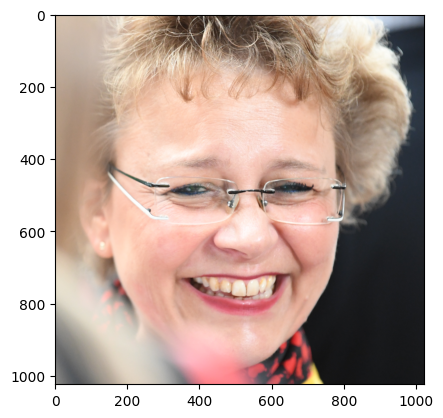


image 1/1 c:\gits\SMILE_tmp\output.png: 192x640 25 teeths, 92.1ms
Speed: 1.0ms preprocess, 92.1ms inference, 2.0ms postprocess per image at shape (1, 3, 192, 640)


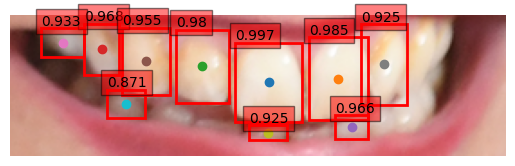

In [19]:
import random as rd
def smiledetect(path):
    img=plt.imread(path)
    plt.imshow(img)
    plt.show()

    nowfig=SMILE(path)
    nowfig.find_all_tooth()
    #mask,sc=nowfig.predict([[50,14]])




    del nowfig


dir_path="app/TrainData/data/"
files=os.listdir(dir_path)
rd.shuffle(files)

for file in files:
    if file=='.DS_Store':
        continue
    smiledetect(dir_path+file)
    break
    
